In [287]:
import os
import numpy as np
import pyqubo as pq
import sympy as sp
import pandas as pd
import seaborn as sns

from PyQubo_formulation import *
from Utilities import *

import neal
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [2]:
root = np.array([0,4], dtype='float')

ulen = 6

# eps1 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)
eps2 = np.around(np.random.uniform(-1, 1, ulen), decimals=2)

domains = np.tile(root, (ulen,1))

# domains[:,0] = domains[:,0]+eps1
domains[:,1] = domains[:,1]+eps2


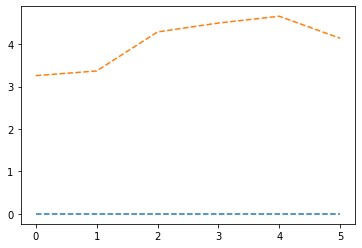

In [3]:
plt.plot(domains[:,0], '--')
plt.plot(domains[:,1], '--')
plt.show()

In [5]:
p = [1,1,1,1,1,1]
Float_Approx(p, domains[1])

3.31734375

In [8]:
nq_u = 6
u = Create_Float_Vec(ulen, nq_u, domains, 'u')
u[0]

Array([(1.630000 * (((((Binary('u[0]') + (0.500000 * Binary('u[1]'))) + (0.250000 * Binary('u[2]'))) + (0.125000 * Binary('u[3]'))) + (0.062500 * Binary('u[4]'))) + (0.031250 * Binary('u[5]')))), (1.685000 * (((((Binary('u[6]') + (0.500000 * Binary('u[7]'))) + (0.250000 * Binary('u[8]'))) + (0.125000 * Binary('u[9]'))) + (0.062500 * Binary('u[10]'))) + (0.031250 * Binary('u[11]')))), (2.145000 * (((((Binary('u[12]') + (0.500000 * Binary('u[13]'))) + (0.250000 * Binary('u[14]'))) + (0.125000 * Binary('u[15]'))) + (0.062500 * Binary('u[16]'))) + (0.031250 * Binary('u[17]')))), (2.250000 * (((((Binary('u[18]') + (0.500000 * Binary('u[19]'))) + (0.250000 * Binary('u[20]'))) + (0.125000 * Binary('u[21]'))) + (0.062500 * Binary('u[22]'))) + (0.031250 * Binary('u[23]')))), (2.330000 * (((((Binary('u[24]') + (0.500000 * Binary('u[25]'))) + (0.250000 * Binary('u[26]'))) + (0.125000 * Binary('u[27]'))) + (0.062500 * Binary('u[28]'))) + (0.031250 * Binary('u[29]')))), (2.070000 * (((((Binary('u[3

In [9]:
empty = np.sum(u).compile()
og_vars = empty.variables
print(og_vars)

/Users/davidbern/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: Operation of Array cannot be done with type:<class 'list'>

In [10]:
nq_mu = 6

muparams = np.array([nq_mu,[0,4]], dtype=object)

In [11]:
maxnorm = Max_Norm_LP(u, 2, muparams, muparams)

model = maxnorm.compile(strength=10)

model_qubo = model.to_qubo(index_label=True)

np.trace(Dict_to_Mat(model_qubo[0]))

TypeError: unsupported operand type(s) for ** or pow(): 'Array' and 'int'

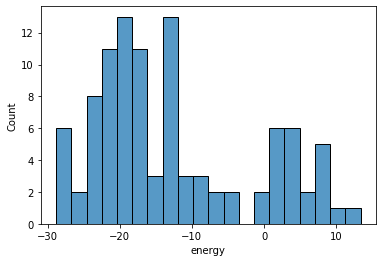

In [200]:
sampler = neal.SimulatedAnnealingSampler()

correct_max = np.max(domains)

model_qubo = model.to_qubo()
    
sampleset = sampler.sample_qubo(model_qubo[0], num_reads=100)

samples = sampleset.samples()

data = sampleset.to_pandas_dataframe()


cwd = os.getcwd()
path = cwd + "/Data/SA/"

data.to_hdf(path+'trialsave.h5', key='a', mode='w')

sns.histplot(data['energy'], bins=20)
plt.show()

In [201]:
low_samps = np.argwhere(sampleset.record['energy'] < np.min(sampleset.record['energy'])+1 ).flatten()

print(low_samps)

strings = np.zeros((len(low_samps),len(og_vars)))

for i in range(len(low_samps)):
    for j in range(len(og_vars)):
        strings[i][j] = samples[int(low_samps[i])][og_vars[j]]
strings


[24 31 94 98]


array([[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 1.]])

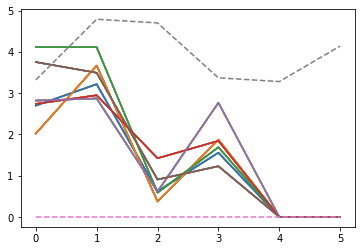

In [202]:
## subbing back into binary approximation to get the result

res = np.zeros((nq_u, ulen))
for n in range(len(strings)):
    for i in range(ulen):
        res[n][i] = float_approx(strings[n][i*nq_u : nq_u*(i+1),], domains[i])

for r in res:
    plt.plot(res)
plt.plot(domains[:,0], '--')
plt.plot(domains[:,1], '--')
plt.show()

In [304]:
sampler = neal.SimulatedAnnealingSampler()

gamma = np.linspace(1,40,20)


results = []
for i in range(len(gamma)):
    
    maxnorm = Max_Norm_LP(u, gamma[i], muparams, muparams)

    model = maxnorm.compile(strength=30)
    
#     model_vars = model.variables
#     unique_vars = model_vars[:(nq_u*ulen+2*nq_mu)]

    model_qubo = model.to_qubo()
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

    samples = sampleset.samples()
    energies = sampleset.record['energy']

    data = sampleset.to_pandas_dataframe()

    cwd = os.getcwd()
    path = cwd + "/Data/SA/"

    data.to_hdf(path+'trialgamma{}.h5'.format(gamma[i]), key='a', mode='w')

    
#     min_energy = np.min(energies)

#     errors = np.zeros(len(samples))
#     for j in range(len(samples)):
#         if np.abs(min_energy - energies[j]) <= np.abs(min_energy)/100:
#             results.append(samples[j])


In [305]:
pd.read_hdf(path+'trialgamma1.h5')

,kq[0],kq[1],kq[2],kq[3],kq[4],kq[5],muq[0],muq[1],muq[2],muq[3],...,q[7] * q[9],q[8],q[8] * q[10],q[8] * q[11],q[8] * q[9],q[9],q[9] * q[10],q[9] * q[11],energy,num_occurrences
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5.654684,1
1,0,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,19.168104,1
2,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,1,1,16.638422,1
3,0,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,1,1,1,10.006206,1
4,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,25.615648,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,1,1,...,0,1,1,1,1,1,1,1,4.010739,1
996,0,0,0,1,0,0,1,1,0,1,...,1,1,1,0,1,1,1,0,27.992217,1
997,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,4.240878,1
998,1,0,0,1,0,0,1,1,0,1,...,0,1,1,0,0,0,0,0,6.205487,1


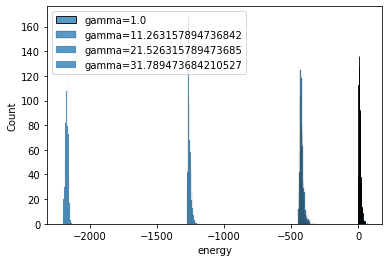

In [308]:
for i in range(4):
    frame = pd.read_hdf(path+'trialgamma{}.h5'.format(gamma[5*i]))
    sns.histplot(frame['energy'], label='gamma={}'.format(gamma[5*i]))
plt.legend()
plt.show()

In [309]:
all_vars = frame.iloc[20].keys()[:140-2]
frame.iloc[min_e]['q[0] * q[1]']

0.0

In [310]:
res = []
sample = []
for s in range(len(gamma)):
    frame = pd.read_hdf(path+'trialgamma{}.h5'.format(gamma[s]))

    min_e = np.argmin(frame['energy'])
    
    sample.append(frame.iloc[min_e])
    
#     min_e_all.append(frame.iloc[min_e][all_vars])#dont need actually
    
    min_e_samps = list(frame[og_vars].iloc[min_e])
    
    res.append(min_e_samps)
print(sample[0]['q[0]'])

0.0


In [321]:
# compute quad error and maxnorm error for each gamma so for each entry 
# of sample and res, respectively.

ceiling = np.max(domains, axis=1)

q_error, problematic = [], [] 

error = []

result = np.zeros((len(gamma),ulen))

for i in range(len(gamma)):
    
    q_er, prob, _ = quad_error(sample[i], og_vars)
    q_error.append(q_er)
    problematic.append(prob)
    
    
    for j in range(ulen):
        result[i][j] = float_approx(res[i][j*nq_u : nq_u*(j+1)], domains[j])
    
    error.append((np.abs(result[i] - ceiling)) / ceiling)

result

array([[0.051875  , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.2075    , 0.4490625 , 0.2203125 , 0.210625  , 0.205     ,
        0.25875   ],
       [2.905     , 1.9459375 , 4.1125    , 2.89609375, 3.02375   ,
        3.2990625 ],
       [2.956875  , 4.19125   , 4.1125    , 3.00140625, 2.9725    ,
        3.751875  ],
       [2.905     , 4.19125   , 4.1125    , 3.00140625, 2.9725    ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.10671875, 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.31734375, 3.075     ,
        3.6871875 ],
       [3.268125  , 4.19125   , 4.1125    , 3.31734375, 3.075     ,
        3.6871875 ],
       [3.268125  , 4

In [292]:
np.max(domains, axis=1)

array([3.32, 4.79, 4.7 , 3.37, 3.28, 4.14])

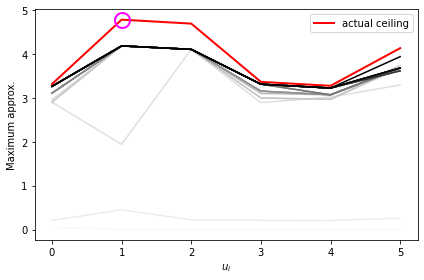

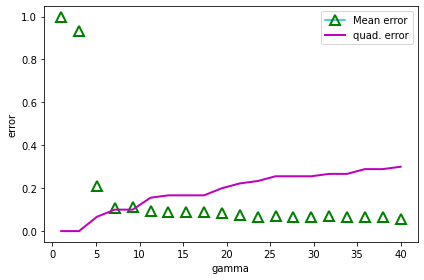

In [392]:
# plt.plot(gamma, error)
cNorm = colors.Normalize(vmin=0, vmax=gamma[-1])
cm = plt.get_cmap('binary')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


plt.plot(ceiling, c='r', lw=2, label='actual ceiling')
for i in range(len(result)):

    plt.plot(result[i], color=scalarMap.to_rgba(gamma[i]))
# plt.plot(error[-1])
plt.ylabel('Maximum approx.')
plt.xlabel(r'$u_i$')
plt.plot(1, np.max(domains), marker="o", markersize=15, markeredgecolor="magenta",
markerfacecolor="None", markeredgewidth=2)


plt.legend()
plt.tight_layout()
plt.savefig('simple_maxnorm_test.png', dpi=300)
plt.show()

for i in range(len(result[:-1])):
    plt.plot(gamma[i], np.mean(error[i]), marker="^", markersize=10, markeredgecolor="green",
        markerfacecolor="None", markeredgewidth=2)

plt.plot(gamma[-1], np.mean(error[-1]), marker="^", markersize=10, markeredgecolor="green",
        markerfacecolor="None", markeredgewidth=2, label='Mean error')
plt.plot(gamma, q_error, c='m', lw=2, label='quad. error')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('error')
plt.tight_layout()
plt.savefig('simple_maxnorm_test__errors.png', dpi=300)
plt.show()

In [30]:
import dimod

sampler_exact = dimod.ExactSolver()
sampler_exact.parameters

model_bqm = dimod.BQM.from_qubo(model_qubo[0])

In [31]:
sampleset = sampler_exact.sample(model_bqm)

samples = sampleset.samples()
energies = sampleset.record['energy']

errors = np.zeros(len(samples))
for j in range(len(samples)):
    errors[j] = quad_error(samples[j], quad_vars)


median = np.median(errors)
mean = np.mean(errors)


ValueError: Maximum allowed dimension exceeded

In [10]:
# Dimond doesn't work so look at SA again

import neal

sampler = neal.SimulatedAnnealingSampler()

sampler.parameters

{'beta_range': [],
 'num_reads': [],
 'num_sweeps': [],
 'beta_schedule_type': ['beta_schedule_options'],
 'seed': [],
 'interrupt_function': [],
 'initial_states': [],
 'initial_states_generator': []}

In [13]:
M = np.linspace(1, 20, 40)

median = np.zeros(len(M))
mean = np.zeros(len(M))

energies = np.zeros(len(M), dtype='object')
samples = np.zeros(len(M), dtype='object')

for i in range(len(M)):
    
    maxnorm = Max_Norm_LP(u, M[i], muparams, muparams)
    
    model = maxnorm.compile(strength=5)

    model_qubo = model.to_qubo()
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

    samples[i] = sampleset.samples()
    energies[i] = sampleset.record['energy']

#     errors = np.zeros(len(samples))
#     for j in range(len(samples)):
#         errors[j] = quad_error(samples[j], quad_vars)
    
#     plt.plot(errors, color=scalarMap.to_rgba(M[i]))
    
#     median[i] = np.median(errors)
#     mean[i] = np.mean(errors)

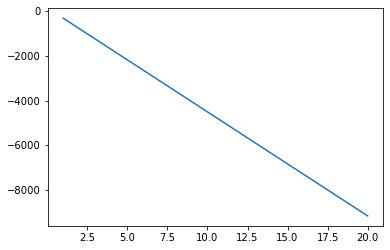

In [21]:
min_e = np.zeros(len(energies))

for i in range(len(energies)):
    min_e[i] = np.min(energies[i])
plt.plot(M, min_e)
plt.show()

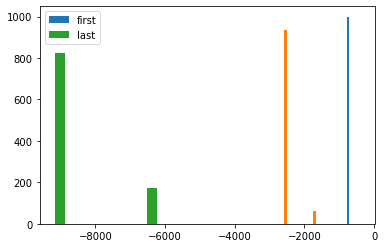

In [38]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=1, vmax=M[-1])
cm = plt.get_cmap('hot_r')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.hist(energies[1], label='first')
plt.hist(energies[10])
plt.hist(energies[39], label='last')
plt.legend()
plt.show()

## Benchamark L$_\infty$-norm 

In [28]:
import os
import numpy as np
import pyqubo as pq
import sympy as sp
import pandas as pd
import seaborn as sns

from PyQubo_formulation import *
from Utilities import *
from Radio import *

import neal
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

### Test 1 - 'y' is known

We define some vector $\mathbf{y}$ with a known maximum, which we should find by minimising $\mu$:

<br>
$$ \text{min }\;\;\mu \;\;s.t.\;\; |y_n|^2 \leq \mu, \forall n$$

<br>

which in unconstrained form is:
<br>
$$\Bigg(\mu +\gamma_1 \sum_n\big(|y_n|^2 + k_n - \mu\big) \Bigg)$$

Create some real vector with obvious maximum:

In [198]:
length = 16
y = np.ones(length)
y[np.random.randint(0,length-1)] = 4
y

array([1., 1., 1., 1., 1., 4., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Create $\mu$ in a range that can capture the maximum.

<br>

Each constraint is satisfied if $\big(|y_n|^2 + k_n - \mu\big)=0$. So in this case, $\mu = 16$, but pretending we don't know, we take $\mu \in [15, 20]$.

In [199]:
nq = 12 ## number of binary vars to approxiamte the float
domain = np.array([15,20]) ## we know mu should converge to 4

float_accuracy = 2**(-nq+1)

mu, muvars = Create_Float_Vec(1, nq, domain, 'mu')
muvars

['mu[0]',
 'mu[1]',
 'mu[2]',
 'mu[3]',
 'mu[4]',
 'mu[5]',
 'mu[6]',
 'mu[7]',
 'mu[8]',
 'mu[9]',
 'mu[10]',
 'mu[11]']

In [200]:
mu = mu[0]

Create the slack variables $k_n$ such that the penalties $(|y_n|^2 + k_n - \mu)^2$ can be satisfied:

In [201]:
# define same domains for all, although we could adapt them more to y.
domains = np.tile([0,15], (length,1))

# approx all elements with same number of binaries, although again could be adapted.
nq_k = 12

k, kvars = Create_Float_Vec(length, nq_k, domains, 'k')

Create the corresponding QUBO problem:

In [202]:
gamma = 50

problem = Max_Norm_LP(y, mu, k, gamma) ## actually has at most quadratic terms in this case
problem_qubo = problem.compile().to_qubo()
problem_qubo

({('k[0]', 'k[2]'): 1406.25,
  ('k[189]', 'mu[6]'): -0.057220458984375,
  ('k[189]', 'mu[7]'): -0.0286102294921875,
  ('k[119]', 'mu[5]'): -0.0286102294921875,
  ('k[133]', 'mu[3]'): -117.1875,
  ('k[2]', 'mu[9]'): -0.91552734375,
  ('k[0]', 'k[9]'): 10.986328125,
  ('k[89]', 'k[92]'): 0.6866455078125,
  ('k[0]', 'mu[6]'): -29.296875,
  ('k[10]', 'mu[3]'): -0.2288818359375,
  ('k[132]', 'k[137]'): 175.78125,
  ('k[0]', 'k[4]'): 351.5625,
  ('k[110]', 'mu[5]'): -14.6484375,
  ('k[77]', 'mu[7]'): -0.457763671875,
  ('k[147]', 'mu[9]'): -0.457763671875,
  ('k[65]', 'k[71]'): 0.0858306884765625,
  ('k[114]', 'mu[5]'): -0.91552734375,
  ('k[142]', 'k[143]'): 0.002682209014892578,
  ('k[101]', 'mu[5]'): -1.8310546875,
  ('k[63]', 'mu[4]'): -14.6484375,
  ('k[121]', 'mu[8]'): -3.662109375,
  ('k[6]', 'k[8]'): 0.34332275390625,
  ('k[112]', 'mu[5]'): -3.662109375,
  ('k[188]', 'mu[10]'): -0.007152557373046875,
  ('k[62]', 'k[66]'): 21.97265625,
  ('k[109]', 'k[113]'): 87.890625,
  ('k[73]', 'k

Define the SA sampler:

In [203]:
sampler = neal.SimulatedAnnealingSampler()

sampler.parameters

{'beta_range': [],
 'num_reads': [],
 'num_sweeps': [],
 'beta_schedule_type': ['beta_schedule_options'],
 'seed': [],
 'interrupt_function': [],
 'initial_states': [],
 'initial_states_generator': []}

In [204]:
sampleset = sampler.sample_qubo(problem_qubo[0], num_reads=100)

samples = sampleset.samples()

data = sampleset.to_pandas_dataframe()

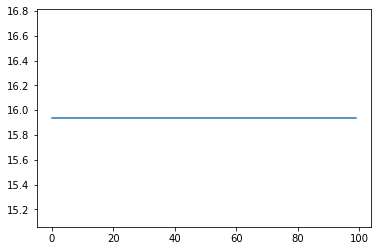

mean: 15.936279296875 std: 0.0


In [205]:
allmus = np.zeros(len(samples))
for i in range(len(allmus)):
    allmus[i] = Float_Approx([samples[0][v] for v in muvars], domain)
allmus
plt.plot(allmus)
plt.show()
print('mean:', np.mean(allmus), 'std:', np.std(allmus))

<AxesSubplot:xlabel='energy', ylabel='Count'>

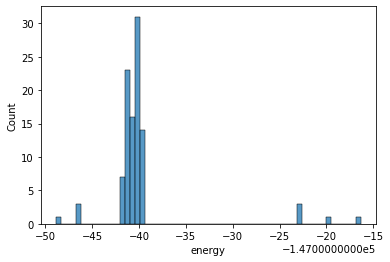

In [206]:
sns.histplot(data['energy'])

In [207]:
def Get_Low_E_Samples(data, e_threshold):
    """
    'data' is Pandas DataFrame of the samplet from annealing.
    'e_threshold' is how far from lowest energy.
    """
    min_e = np.min(data['energy'])
    
    if e_threshold == 0:
        min_e_idx = data[data['energy'] == min_e].index.tolist()
    else:
        min_e_idx = data[data['energy'] <= min_e + e_threshold*np.abs(min_e)].index.tolist()
    
    # dataframe has variable names as headers
    binaries = data.columns[:data.shape[1]-2]
    
    # more useful for us as dictionary
    min_e_samps_dict = data[binaries].to_dict('index')
    
    # even more useful as an ndarray of dictionaries
    min_e_samps = np.asarray([min_e_samps_dict[k] for k in min_e_idx])
    
    return min_e_samps

In [208]:
min_samples = Get_Low_E_Samples(data, 0)
len(min_samples)

1

In [209]:
myvalues = [min_samples[0][k] for k in muvars]

Float_Approx(myvalues, domain)
# min_samples[0][*muvars]

15.936279296875

In [210]:
# q_error, problematic = [], [] 

error = []

mu_result = np.zeros(len(min_samples))
k_result = np.zeros((len(min_samples), length))

for i in range(len(min_samples)):
    
#     q_er, prob, _ = Quad_Error(sample[i], og_vars)
#     q_error.append(q_er)
#     problematic.append(prob)

#     for j in range(ulen):
    musamps = [min_samples[i][k] for k in muvars]
    mu_result[i] = Float_Approx(musamps, domain)
    
    ksamps = [min_samples[i][k] for k in kvars]
    for j in range(length):
            k_result[i][j] = Float_Approx(ksamps[j*nq_k : nq_k*(j+1)], domains[j])
    
#     error.append((np.abs(result[i] - ceiling)) / ceiling)

mu= [15.9362793] +-0.00048828125


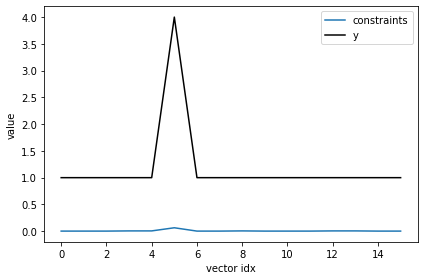

In [211]:
print('mu=', mu_result,'+-{}'.format(float_accuracy) )

for kres in k_result:
    plt.plot((kres-mu_result[0]+np.abs(y)**2), label='constraints') 

plt.plot(y, 'k', label='y')
plt.xlabel('vector idx')
plt.ylabel('value')
plt.legend()
plt.tight_layout()
plt.show()

Now for various $\gamma_1$ values:


KeyError: 'k[0]'

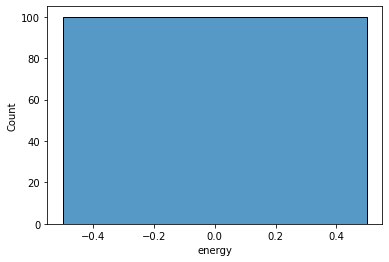

In [212]:
gamma = np.linspace(0,200, 10)

mu_mean, mu_std = [], []

mu_result, k_result = [], []

for i in range(len(gamma)):
    
    problem = Max_Norm_LP(y, mu, k, gamma[i]) ## actually has at most quadratic terms in this case
    problem_qubo = problem.compile().to_qubo()
    
    sampleset = sampler.sample_qubo(problem_qubo[0], num_reads=100)

    samples = sampleset.samples()

    data = sampleset.to_pandas_dataframe()
    min_samples = Get_Low_E_Samples(data, 0)
    
    allmus = np.zeros(len(samples))
    for i in range(len(allmus)):
        allmus[i] = Float_Approx([samples[0][v] for v in muvars], domain)
    
    mu_mean.append(np.mean(allmus))
    mu_std.append(np.std(allmus))
    
    sns.histplot(data['energy'])
    
    
    
    mu_res = np.zeros(len(min_samples))
    k_res = np.zeros((len(min_samples), length))

    for i in range(len(min_samples)):

        musamps = [min_samples[i][k] for k in muvars]
        mu_res[i] = Float_Approx(musamps, domain)

        ksamps = [min_samples[i][k] for k in kvars]
        for j in range(length):
                k_res[i][j] = Float_Approx(ksamps[j*nq_k : nq_k*(j+1)], domains[j])
    
    mu_result.append(mu_res)
    k_result.append(k_res)
    
plt.show()

### Testing full 2x2

Create some channel real matrix:

In [8]:
H = np.around(Channel_Rayleigh(2, 2), decimals=2)
H

array([[1.16+0.76j, 1.26+0.78j],
       [1.87+0.59j, 0.93+0.82j]])

Create some message s:

In [9]:
QAMsize = 16 
s = Create_S(2, QAMsize)
s

array([ 3.+1.j, -1.+1.j])